# Part 3 : Build Model using CatBoost

Python Packages Used : 
1. data processing : numpy, pandas, regular expression(re)
2. data modeling   : sklearn, CatBoost, Hyperopt

### Organization of the Notebook

Part 1: Load Packages 

Part 2: Read Data 

Part 3: Process Data 

Part 4: Build Model

1. Check Class Labels & Label Weights

2. Split Data : Train (80%) and Test (20%)

3. i) Use Default Parameter values to build a model. ii) Use Hyperopt to get the Optimzed Hyprer-Parameters on Train data using 5-fold Cross-Validation 

4. Build Model using Optimzed Parameters 

Part 5: Model Validation

1. Apply Model on the Test Data

2. Model Performnace on the Test Data

3. Feature Importance 

## Part 1: Load Packages

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import re

#from scipy.special import rel_entr
#from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split

In [4]:
import shap

In [5]:
%matplotlib inline

#### Note : CatBoost Installation

!pip install catboost

!pip install ipywidgets

!jupyter nbextension enable --py widgetsnbextension

#### Note : Hyperopt installation

!pip install hyperopt

In [6]:
import hyperopt
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_confusion_matrix, get_roc_curve
from sklearn.metrics import precision_recall_curve

## Part 2: Read Data

In [7]:
df = pd.read_excel("data_customerSatisfaction.xlsx", engine="openpyxl")

In [8]:
print("Shape of the Dataframe :", df.shape)

Shape of the Dataframe : (129880, 24)


## Part 3: Process Data

In [9]:
print( df.columns.to_list() )

['id', 'SatisfactionType', 'Gender', 'CustomerType', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [10]:
"""Fix Column Names : Remove White Spaces & Slashes"""
oldName = df.columns.to_list()
newName = [re.sub(" ", "_", x.title()) for x in oldName]
colName = {oldName[i]: newName[i] for i in range(len(oldName))} 
df = df.rename(columns=colName)
df = df.rename(columns={"Departure/Arrival_Time_Convenient":"Departure_Arrival_Time_Convenient"})

In [11]:
#print( df.dtypes )

#### Drop Column "id"

Unique integer. It does not have any leverage in the modeling compared to other features.

In [12]:
df = df.drop(["Id"], axis=1)  

#### Replace Age Null Values by Median Age

In [13]:
medianAge = df.loc[df['Age'].isnull()==False, 'Age'].median()
df.loc[df['Age'].isnull()==True, 'Age'] = medianAge

#### Leg Room Service has Catagores like 0,1,2,3,4,5,44,55. Change 44,55 to 0 

In [14]:
"""Fix Leg Room Service"""
df.loc[ df["Leg_Room_Service"] > 5, "Leg_Room_Service"] = 0

#### Replace Food and Drink Null Values by 1

Find the subset of data having "Online Boarding=Null"

Explore the data property on all other categorical columns in this subset

Assign category to "Online Boarding=Null" based on the observed property of the subset 

In [15]:
"""Fix Food and Drink"""
#df[ df["Food and drink"].isnull()==True ]   # DisLoyal but Satisfied
df.loc[ df["Food_And_Drink"].isnull()==True, "Food_And_Drink" ] = 1.0

#### Replace Online Boarding Null Values  by 1

Following the procedure in "Food and Drink"

In [16]:
"""Fix Online Boarding"""
# df[ df["Online boarding"].isnull()==True ] # Loyal and Satisfied
df.loc[ df["Online_Boarding"].isnull()==True, "Online_Boarding" ] = 1.0

#### Maximum Flight Distance is 9999999. Replace it by Column Median

Flight Distance has outliers

Replace outliers by the column mdedian. Median itself is insensitive to outliers in the data.

In [17]:
"""Flight Distance"""
# print( df["Flight Distance"].mean() ) 
# print( df["Flight Distance"].max() )
distList = sorted( df["Flight_Distance"].unique(), reverse= True)
df.loc[ df["Flight_Distance"] > distList[1],  "Flight_Distance"] = df["Flight_Distance"].median()
# print( df["Flight Distance"].mean() ) 
# print( df["Flight Distance"].max() )

#### Replace Baggage Handling Null values by 0

In [18]:
df.loc[ df["Baggage_Handling"].isnull() == True, "Baggage_Handling" ] = 0

#### Departure Delay in Minutes and Arrival Delay in Minutes are Strongly Correlated (r ~ 0.99) 

In [19]:
"""Drop Arrival Delay in Minutes instead of Departure Delay in Minutes"""
df = df.drop(["Arrival_Delay_In_Minutes"], axis=1)  

#### Make the Dataframe with Appropriate Data Types 

In [20]:
df_feature = df.dtypes.to_frame().reset_index().rename(columns={"index": "Feature", 0: 'FeatureType'})
theObjects = df_feature[ df_feature['FeatureType'] == 'object']
df_object  = df[ theObjects['Feature'] ].copy() 

Feature with Float Data Type

In [21]:
df_float = df[['Age','Flight_Distance','Departure_Delay_In_Minutes']].copy()
df_float = df_float.astype('float64')
nFloat = df_float.shape[1]

Feature with Interger Data Type

In [22]:
object_float_list = df_object.columns.to_list() + df_float.columns.to_list() 
colList = set( df.columns.to_list() )
ofList  = set( object_float_list )
colList.difference_update( ofList )
df_int = df[ list(colList) ].copy()
df_str = df_int.astype('str')

Convert Categorical to Integer Type 

0 = "satisfied"
1 = "neutral or dissatisfied"

In [23]:
df_object['Y'] = df_object.apply(lambda row: 0 if row.Satisfactiontype=="satisfied" else 1, axis=1)

In [24]:
# df_object['Gender'] = df_object.apply(lambda row: 0 if row.Gender=="Female" else 1, axis=1)
# df_object['Customer_Type'] = df_object.apply(lambda row: 0 if row.Customer_Type=="disloyal Customer" else 1, axis=1)
# df_object['Type_Of_Travel'] = df_object.apply(lambda row: 0 if row.Type_Of_Travel=="Business travel" else 1, axis=1)
# df_object['Class'] = df_object.apply(lambda row: 0 if row.Class=="Business" else 1 if row.Class=="Eco" else 2, axis=1)

In [25]:
"""Dropping Satisfactiontype. It is replaced by feature Y"""
df_object = df_object.drop(['Satisfactiontype'], axis=1)

Concate the Splitted Parts Back

In [26]:
"""Final Dataframe"""
df = pd.concat([df_object, df_str, df_float], axis=1)
df = df.sample(frac=1.0, replace=False, random_state=1)
print(f'Shape of the final dataframe : {df.shape}')

Shape of the final dataframe : (129880, 22)


-------

## Part 4: Build Model 

#### 5.1 : Class Labels & Weights

Label values extraction

In [33]:
y = df.Y
X = df.drop('Y', axis=1)

Categorical Features Declaration

In [34]:
total_features = list(range(0, X.shape[1]))
print(f'Total features : {total_features}' )
print(f'Remove {nFloat} numeric features ...' )
categorical_features_indices   = total_features[:-nFloat]
print(f'Categorical features : {categorical_features_indices}')

Total features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Remove 3 numeric features ...
Categorical features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


#### The Class Distribution in the Dataset

0 = "satisfied" (postive class)

1 = "neutral or dissatisfied" (negative class)

In [35]:
print(f'Class Labels: {set(y)}')
print(f'Zero Count = {len(y) - sum(y)}, One Count = {sum(y)}')
zero_frac = (len(y)-sum(y))/len(y)
one_frac  =  sum(y)/len(y)
print(f'Class Distributions 0:1 : {round(zero_frac,4), round(one_frac,4)}')

Class Labels: {0, 1}
Zero Count = 56428, One Count = 73452
Class Distributions 0:1 : (0.4345, 0.5655)


Create Class Weight

In [36]:
zero_weight = one_frac
one_weight  = zero_frac
print(f'Class Weights : {round(zero_weight,4), round(one_weight,4)}')
class_weight = np.array([zero_weight if x==0 else one_weight for x in y])

Class Weights : (0.5655, 0.4345)


#### 5.2 : Data Split Train (80) - Test (20)

In [37]:
theSeed = 201 #np.random.randint(101,499)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'test data : {X_test.shape}')

train data: (90916, 21)
test data : (38964, 21)


Create Pool for Convenience

In [38]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool  = Pool(X_test, y_test, cat_features=categorical_features_indices)

#### 5.3 : Train Model 

#### Using Default Hyper-Parameters

In [39]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=theSeed,
    loss_function='Logloss',
    logging_level='Silent')

In [40]:
fit = model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Silent',  
    plot=False)

In [41]:
evaluate_test = fit.eval_metrics(test_pool, ['AUC'], plot=False)

theAUC = np.mean( np.array(evaluate_test['AUC']) )
print(f"The AUC : { round(theAUC,4) }")

confusion_matrix = get_confusion_matrix(fit, test_pool)
print( confusion_matrix )
accuracy = accuracy_score(y_test, model.predict(X_test))
print( round(accuracy,4) )

feature_importances = fit.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, round(score,4)))

The AUC : 0.995
[[15877.   915.]
 [  436. 21736.]]
0.9653
Type_Of_Travel: 25.0315
Inflight_Wifi_Service: 23.6541
Online_Boarding: 8.3528
Customertype: 7.3797
Class: 7.3584
Inflight_Entertainment: 4.5905
Age: 3.7085
Checkin_Service: 2.82
Gate_Location: 2.766
Baggage_Handling: 2.3334
Inflight_Service: 2.3093
Seat_Comfort: 1.8201
Flight_Distance: 1.5105
Cleanliness: 1.3483
On-Board_Service: 1.2167
Departure_Arrival_Time_Convenient: 1.1793
Ease_Of_Online_Booking: 0.9875
Departure_Delay_In_Minutes: 0.6878
Leg_Room_Service: 0.6111
Food_And_Drink: 0.3225
Gender: 0.0118


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


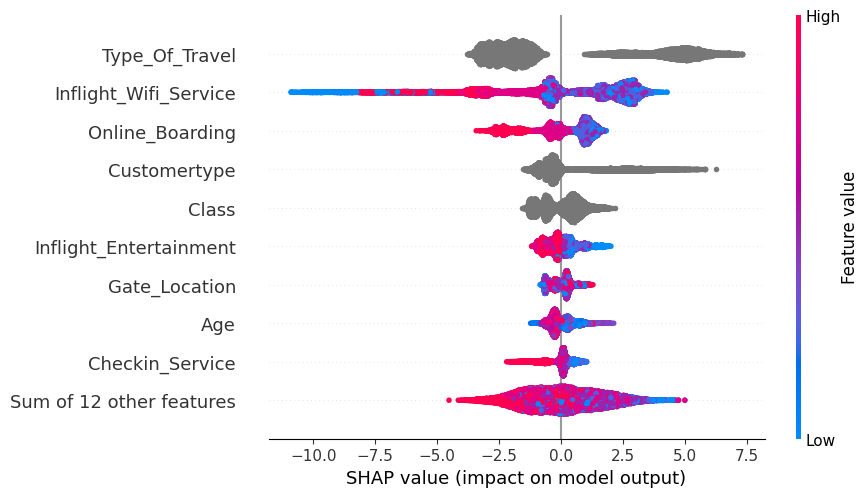

In [42]:
explainer = shap.Explainer(fit)
shap_values = explainer(X_test)
#shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

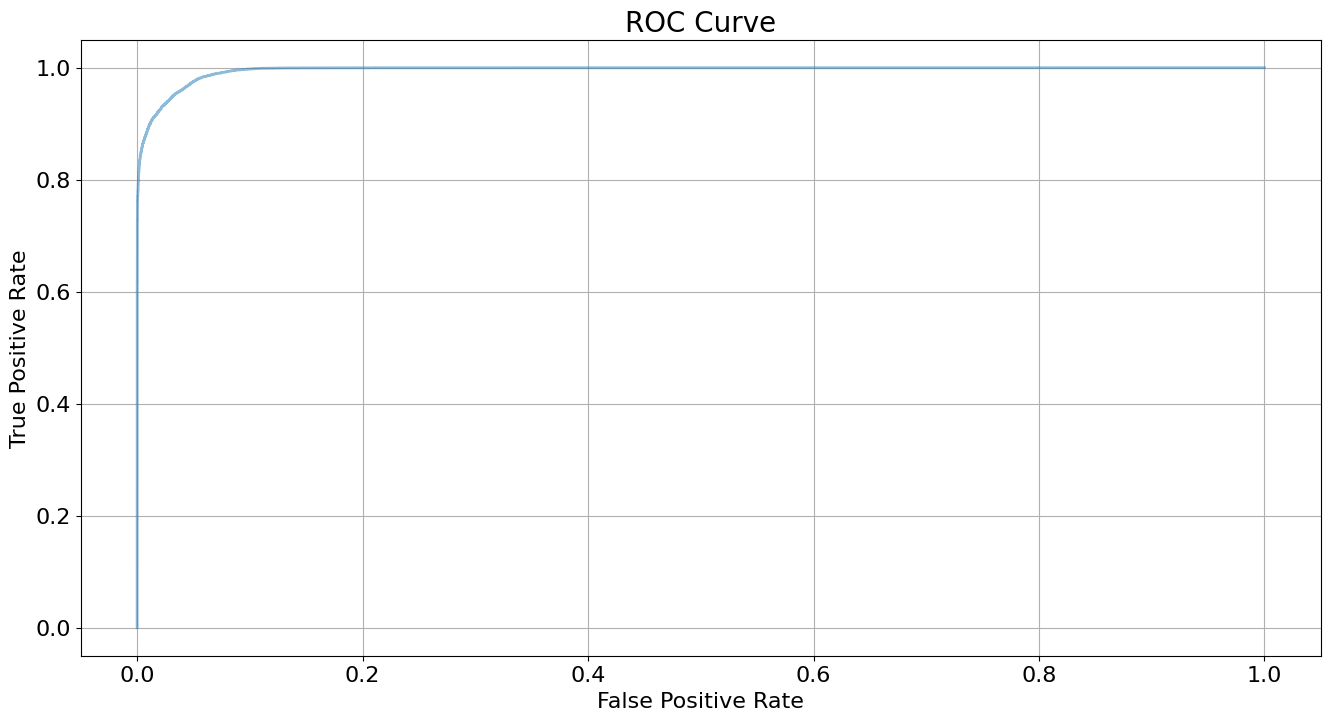

In [43]:
fpr, tpr, thresholds = get_roc_curve(fit, test_pool, plot=True)

#### Optimizinng Hyper-Parameter 

For simplicity and sake of time, optimized teh following two critical parameters: 

i. learning_rate 

ii. l2_leaf_reg 

In [44]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=50,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False,
        loss_function='Logloss')
    
    pool = Pool(X, y, cat_features=categorical_features_indices)
    params = model.get_params()
    cv_data = cv(pool=pool, params=params, fold_count=5)
    
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [45]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-2, 4e-1)}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=25,
    trials=trials,
    rstate=None) #RandomState(123))

print(f'The best parameters : {best}')

  0%|                                                                      | 0/25 [00:00<?, ?trial/s, best loss=?]Training on fold [0/5]

bestTest = 0.9580013089
bestIteration = 47

Training on fold [1/5]

bestTest = 0.9588482119
bestIteration = 48

Training on fold [2/5]

bestTest = 0.9604635048
bestIteration = 48

Training on fold [3/5]

bestTest = 0.9614629451
bestIteration = 48

Training on fold [4/5]

bestTest = 0.9583060635
bestIteration = 49

  4%|█▋                                         | 1/25 [00:14<05:43, 14.30s/trial, best loss: 0.04059899199657413]Training on fold [0/5]

bestTest = 0.9442583824
bestIteration = 49

Training on fold [1/5]

bestTest = 0.945528737
bestIteration = 49

Training on fold [2/5]

bestTest = 0.9466815522
bestIteration = 48

Training on fold [3/5]

bestTest = 0.9497978826
bestIteration = 49

Training on fold [4/5]

bestTest = 0.944292589
bestIteration = 49

  8%|███▍                                       | 2/25 [00:28<05:29, 14.31s/trial, best loss: 

 72%|█████████████████████████████▌           | 18/25 [04:13<01:35, 13.69s/trial, best loss: 0.038843537266155415]Training on fold [0/5]

bestTest = 0.9596181237
bestIteration = 49

Training on fold [1/5]

bestTest = 0.9586172383
bestIteration = 49

Training on fold [2/5]

bestTest = 0.9613104404
bestIteration = 48

Training on fold [3/5]

bestTest = 0.9613089509
bestIteration = 48

Training on fold [4/5]

bestTest = 0.9585370549
bestIteration = 43

 76%|███████████████████████████████▏         | 19/25 [04:26<01:21, 13.57s/trial, best loss: 0.038843537266155415]Training on fold [0/5]

bestTest = 0.9452592678
bestIteration = 49

Training on fold [1/5]

bestTest = 0.9461061708
bestIteration = 49

Training on fold [2/5]

bestTest = 0.9489528796
bestIteration = 49

Training on fold [3/5]

bestTest = 0.9466794995
bestIteration = 49

Training on fold [4/5]

bestTest = 0.9470644851
bestIteration = 49

 80%|████████████████████████████████▊        | 20/25 [04:40<01:09, 13.81s/trial, best loss:

Build the Model with the Best Hyper-Parameters

In [46]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=250,
    eval_metric='Accuracy',
    random_seed=42,
    loss_function='Logloss',
    logging_level='Silent')

Check : Mean Accuracy on Validation Data"

In [47]:
pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
params = model.get_params()
cv_data = cv(pool=pool, params=params, fold_count=5, seed=42)

mean_accuracy = np.max(cv_data['test-Accuracy-mean'])
print(f'Mean Accuracy on the Validation Data: {round(mean_accuracy,4)}')

Mean Accuracy on the Validation Data: 0.9634


## Part 6: Model Validation

#### 6.1: Apply Model on the Test Dataset

In [48]:
# fit = model.fit(
#     train_pool, 
#     eval_set=test_pool,
#     cat_features=categorical_features_indices,
#     logging_level='Silent', 
#     plot=False)

In [49]:
fit = model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Silent',  
    plot=False)

#### 6.3: Model Accuracy on Test Data

In [50]:
eval_test = fit.eval_metrics(test_pool, ['AUC'], plot=False)

In [51]:
theAUC = np.mean( np.array(eval_test['AUC']) )
print(f"The AUC : { round(theAUC,4) }")

The AUC : 0.9945


In [52]:
confusion_matrix = get_confusion_matrix(fit, test_pool)
print(confusion_matrix)

[[15868.   924.]
 [  463. 21709.]]


In [53]:
accuracy = accuracy_score(y_test, model.predict(X_test))
print( round(accuracy,4) )

0.9644


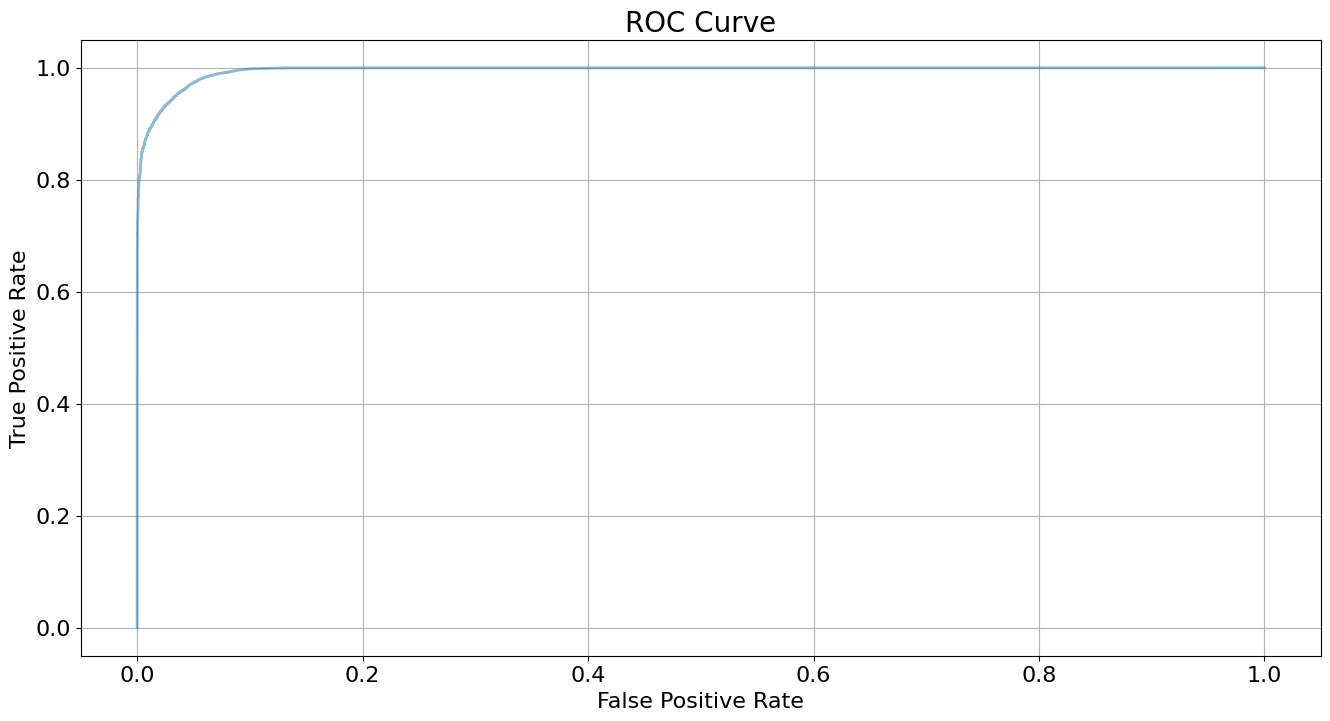

In [54]:
fpr,tpr,thresholds = get_roc_curve(fit, test_pool, plot=True)

#### 6.2: Feature Importance

In [55]:
fit.get_feature_importance(prettified=True)
# feature_importances = fit.get_feature_importance(train_pool)
# feature_names = X_train.columns
# for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
#     print('{}: {}'.format(name, round(score,4)))

,Feature Id,Importances
0,Type_Of_Travel,27.958598
1,Inflight_Wifi_Service,21.214865
2,Online_Boarding,9.635924
3,Class,6.416854
4,Customertype,5.793136
5,Baggage_Handling,5.292735
6,Age,3.225973
7,Inflight_Entertainment,2.876387
8,Gate_Location,2.498330
9,Inflight_Service,2.344185


SHAP Values & Feature Importance   

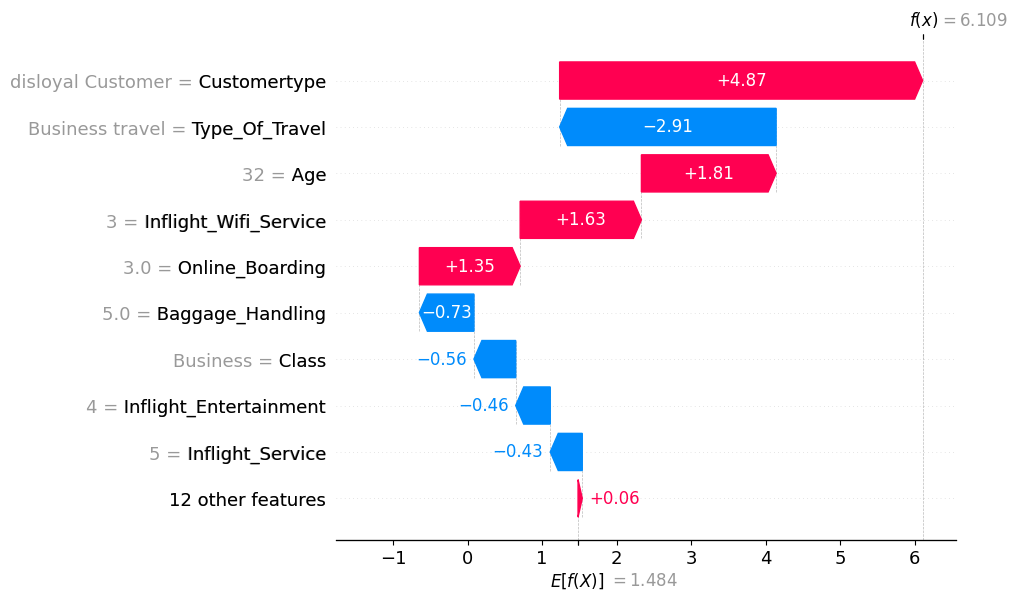

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


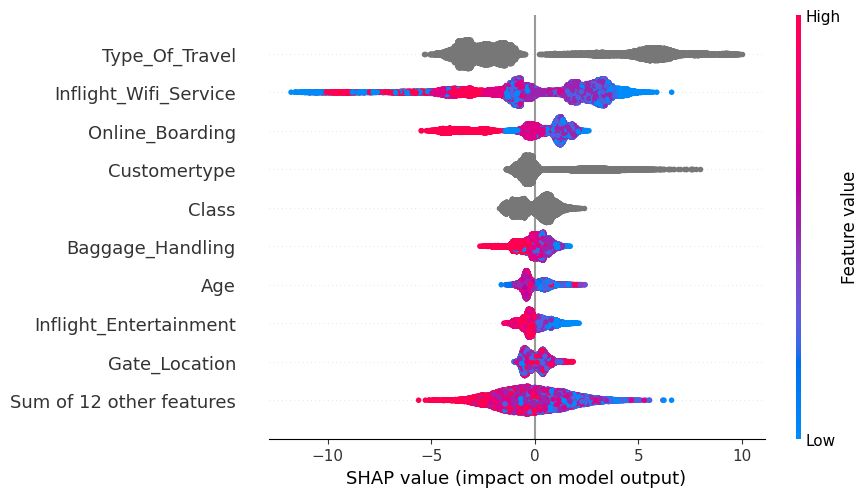

In [56]:
explainer = shap.Explainer(fit)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

In [57]:
# eval_test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
# (fpr, tpr, thresholds) = get_roc_curve(model, eval_test_pool)
# roc_auc = auc(fpr, tpr)

In [58]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16, 8))
# lw = 2

# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.grid(True)
# plt.xlabel('False Positive Rate', fontsize=16)
# plt.ylabel('True Positive Rate', fontsize=16)
# plt.title('Receiver Operating Characteristic', fontsize=20)
# plt.legend(loc="lower right", fontsize=16)
# plt.show()

In [59]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

eval_test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
curve = get_roc_curve(model, eval_test_pool)

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

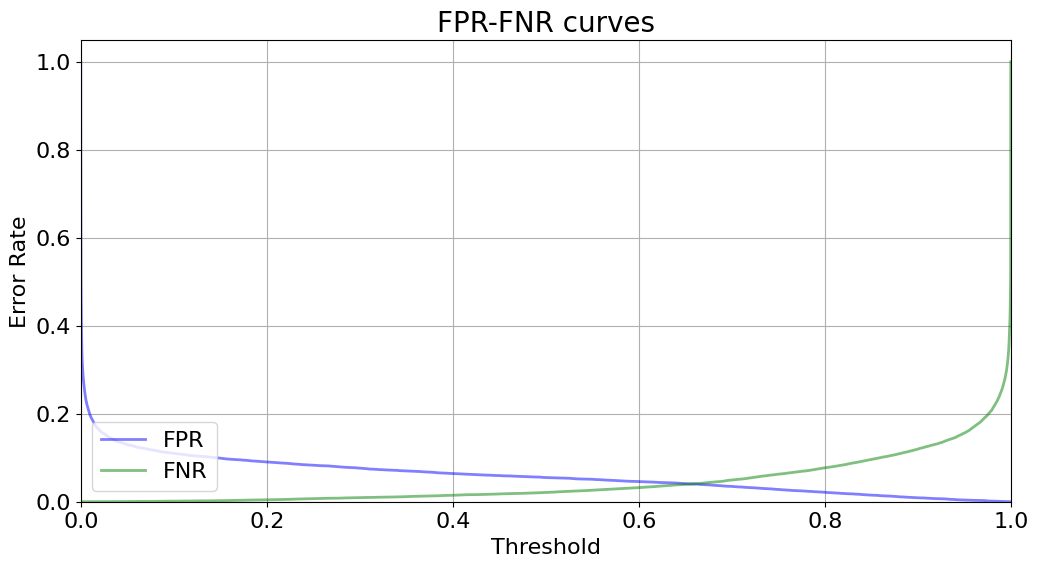

In [60]:
import matplotlib.pyplot as plt
plt.figure( figsize=(12,6) )
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()